In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sqlite3
import spacy
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from dotenv import load_dotenv
load_dotenv()

# Load the SpaCy German language model
nlp = spacy.load("de_core_news_sm")

In [6]:
def german_stopwords_plain():

  # Specify the path to your text file
  file_path = './german_stopwords_plain.txt'

  # Open the file in read mode
  with open(file_path, 'r') as file:
      # Read the content of the file
      lines = file.readlines()

      # Filter out lines starting with ';'
      filtered_lines = [line.strip() for line in lines if not line.startswith(';')]

      # Concatenate the non-comment lines into a single string
      content = '\n'.join(filtered_lines)

      # Split the content into words
      words = content.split()

  return words

In [7]:
def german_stopwords_full():

  # Specify the path to your text file
  file_path = './german_stopwords_full.txt'

  # Open the file in read mode
  with open(file_path, 'r') as file:
      # Read the content of the file
      lines = file.readlines()

      # Filter out lines starting with ';'
      filtered_lines = [line.strip() for line in lines if not line.startswith(';')]

      # Concatenate the non-comment lines into a single string
      content = '\n'.join(filtered_lines)

      # Split the content into words
      words = content.split()

  return words

In [23]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

In [28]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=5000, replace=False)

    data_array = np.asarray(data[max_items, :].todense())

    pca = PCA(n_components=30).fit_transform(data_array)
    tsne = TSNE(perplexity=30).fit_transform(pca)
    
    
    idx = np.random.choice(range(pca.shape[0]), size=500, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNEnlp = spacy.load("de_core_news_sm") Cluster Plot')
    


In [32]:
# Create your connection.
# sqlite_conn = sqlite3.connect('weiterbildung_analysis.db')
sqlite_conn = sqlite3.connect('weiterbildung_new_data.db')

df = pd.read_sql_query("SELECT angebot_id, angebot_inhalt FROM weiterbildung_data", sqlite_conn)
df = df.drop_duplicates(subset=['angebot_id'])
df


,angebot_id,angebot_inhalt
0,13804824,"Die Arbeit mit Flipchart, Stiften und Farben i..."
1,13804169,Inhalte:• Einführung in das Konzept der Kolleg...
2,13804805,Inhalte:• Input zu den Themen Zieltheorie und ...
3,13804193,"Unter der Bezeichnung ""Community Reinforcement..."
4,13804815,Mehr als 12 Millionen Menschen in Deutschland ...
...,...,...
724426,14670154,Ziel des Kurses ist der Erwerb einer neuen Hal...
724452,14670155,"Neue Erkenntnisse aus den Neurowissenschaften,..."
724454,14978034,Einzel- und TeamcoachingsModerationMediationMi...
724484,12824351,Die Reise im DetailENTSPANNEN MIT BIOPHILIA-EF...


## Lemmatizer

In [35]:
# Function to lemmatize text using SpaCy
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

# Apply lemmatization to the text column
df['lemmatized_text'] = df['angebot_inhalt'].apply(lemmatize_text)

df

,angebot_id,angebot_inhalt,lemmatized_text
0,13804824,"Die Arbeit mit Flipchart, Stiften und Farben i...",der Arbeit mit Flipchart -- Stift und Farbe in...
1,13804169,Inhalte:• Einführung in das Konzept der Kolleg...,Inhalte:• Einführung in der Konzept der Kolleg...
2,13804805,Inhalte:• Input zu den Themen Zieltheorie und ...,Inhalte:• Input zu der Thema Zieltheorie und W...
3,13804193,"Unter der Bezeichnung ""Community Reinforcement...",unter der Bezeichnung -- Community Reinforceme...
4,13804815,Mehr als 12 Millionen Menschen in Deutschland ...,mehr als 12 Million Mensch in Deutschland kons...
...,...,...,...
724426,14670154,Ziel des Kurses ist der Erwerb einer neuen Hal...,Ziel der Kurses sein der Erwerb ein neu Haltun...
724452,14670155,"Neue Erkenntnisse aus den Neurowissenschaften,...",neu Erkenntnis aus der Neurowissenschaft -- de...
724454,14978034,Einzel- und TeamcoachingsModerationMediationMi...,Einzel und TeamcoachingsModerationMediationMit...
724484,12824351,Die Reise im DetailENTSPANNEN MIT BIOPHILIA-EF...,der Reise in DetailENTSPANNEN MIT BIOPHILIA-EF...


## Execution

/home/azhar/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters


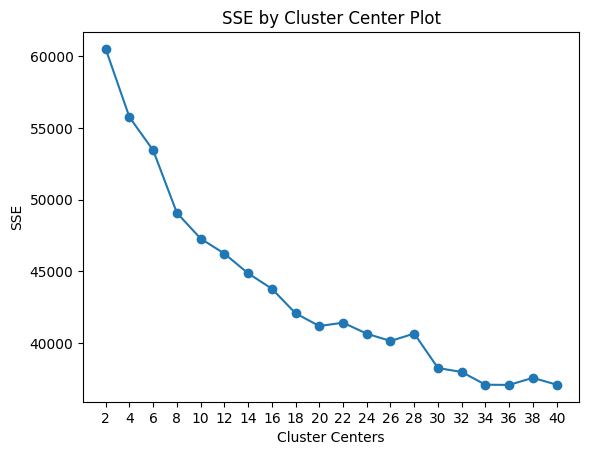

In [36]:
tfidf = TfidfVectorizer(
    min_df = 5000,
    max_df = 0.95,
    max_features = 300,
    stop_words=german_stopwords_full()
)
tfidf.fit(df.lemmatized_text)
text = tfidf.transform(df.lemmatized_text)

# print(text)
find_optimal_clusters(text, 40)


/home/azhar/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


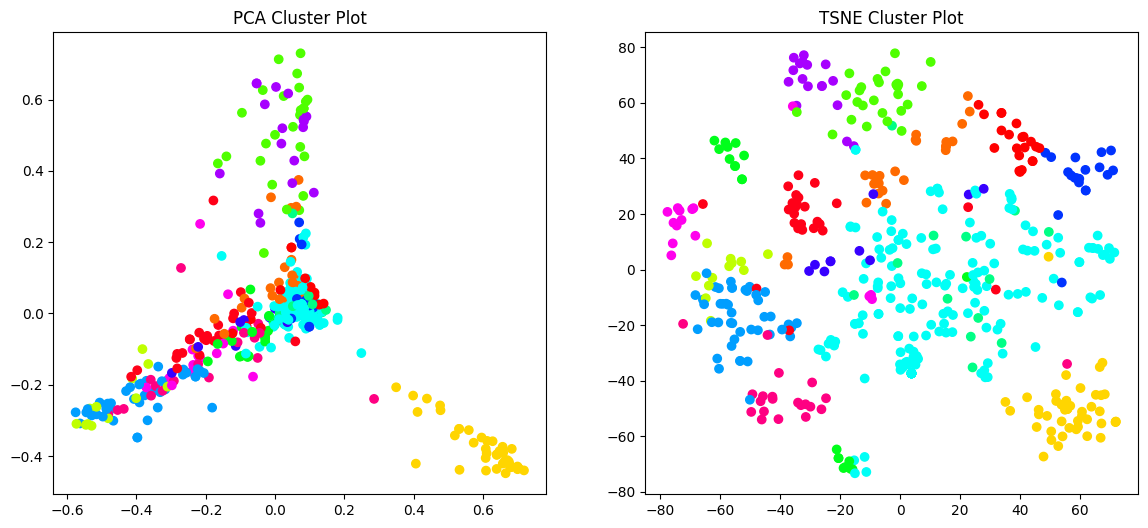

In [39]:
clusters = MiniBatchKMeans(n_clusters=15, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)
plot_tsne_pca(text, clusters)

In [40]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names_out(), 10)


Cluster 0
digital,durchführung,unternehmen,umgang,kommunikation,planung,vorbereitung,prüfung,praktisch,ausbildung

Cluster 1
überblick,präsentation,vorbereitung,ausbildung,analyse,prozeß,planung,system,zertifizierung,management

Cluster 2
künstliche,vertiefung,praxis,technologi,beruflich,lehrgangsinhalte,aktualisiert,intelligenz,ki,tag

Cluster 3
digital,rolle,management,it,methode,transformation,projekt,scrum,projektmanagement,agil

Cluster 4
analyse,optimierung,digital,mail,strategie,management,social,media,content,marketing

Cluster 5
bereich,arbeit,digital,mail,software,grundlage,funktion,microsoft,office,ms

Cluster 6
kenntnis,wissen,erstellen,lernen,bereich,arbeit,anwendung,grundlage,kurs,verschieden

Cluster 7
funktion,kurs,erstellen,inhalt,microsoft,kommunikation,arbeit,einführung,umgang,grundlage

Cluster 8
methode,kompetenz,projekt,scrum,microsoft,digitalisierung,office,agil,digital,projektmanagement

Cluster 9
marketing,entwicklung,technisch,zertifizierung,praktisch,managem